<a href="https://colab.research.google.com/github/shpotes/traffic-counter/blob/master/notebooks/loss-data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---


#◢ Verify Correct Runtime Settings

**<font color='#FF000'> IMPORTANT </font>**

In the "Runtime" menu for the notebook window, select "Change runtime type." Ensure that the following are selected:
* Runtime Type = Python 3
* Hardware Accelerator = GPU 


#◢ Git clone and install Faster R-CNN

In [1]:
!git clone https://github.com/shpotes/traffic-counter
%cd traffic-counter/notebooks

Cloning into 'traffic-counter'...
remote: Enumerating objects: 905, done.
^Cceiving objects:  18% (163/905), 4.29 MiB | 1.20 MiB/s      
[Errno 2] No such file or directory: 'traffic-counter/notebooks'
/home/santiago/Projects/object-detection/notebooks


#◢ Setup

In [2]:
!pip install -r ../requirements.txt

     |████████████████████████████████| 86.3MB 208kB/s 
     |████████████████████████████████| 26.6MB 58.5MB/s 
     |████████████████████████████████| 501kB 52.6MB/s 
     |████████████████████████████████| 4.3MB 41.8MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0
  Found existing installation: opencv-python 3.4.5.20
    Uninstalling opencv-python-3.4.5.20:
      Successfully uninstalled opencv-python-3.4.5.20


In [1]:
import sys
import os
import json
from itertools import groupby
from operator import itemgetter
from typing import List, Tuple, Dict

import gin
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

sys.path.append('..')

from vehicle_nowcasting.data.data_loader import *
from vehicle_nowcasting.data.generate_anchors import generate_anchors as gen_anch
from vehicle_nowcasting.utils import iou, plot_bb, change_box_order, compute_stride_from_receptive_field

%matplotlib inline

##◢ Load metadata

In [2]:
main_dir = '..'
data_dir = os.path.join(main_dir, 'data')
metadata = pd.read_csv('../data/metadata.csv')
label_map = json.load(open('../data/label_map.json', 'r'))

In [3]:
sources = build_source_from_metadata(metadata,
                                     label_map,
                                     data_dir)

In [4]:
sources[:2]

[('../data/train/15-02-15-20:17.jpg',
  [(1, 225, 117, 411, 281),
   (3, 335, 212, 456, 329),
   (3, 555, 140, 607, 210),
   (4, 470, 211, 553, 307),
   (4, 442, 138, 519, 202),
   (4, 24, 238, 147, 334),
   (4, 166, 176, 244, 258),
   (4, 388, 110, 435, 167),
   (4, 505, 96, 557, 149),
   (1, 436, 39, 528, 126),
   (3, 546, 66, 593, 106),
   (3, 615, 59, 663, 99)]),
 ('../data/train/33.09-14-17:43.jpg',
  [(3, 378, 288, 579, 474),
   (3, 271, 7, 346, 58),
   (3, 558, 191, 704, 307),
   (3, 555, 132, 695, 214),
   (3, 405, 65, 498, 126),
   (3, 302, 75, 393, 135),
   (3, 227, 32, 293, 72),
   (3, 213, 1, 268, 26),
   (3, 71, 16, 120, 58),
   (2, 8, 39, 101, 155),
   (5, 83, 57, 109, 96),
   (5, 148, 143, 187, 203),
   (5, 150, 108, 191, 161),
   (5, 349, 373, 443, 477),
   (5, 310, 437, 384, 480)])]

In [5]:
ds = make_dataset(sources, mode=None)

W0911 23:46:25.227402 139946029143872 deprecation.py:323] From /home/santiago/anaconda3/envs/CV/lib/python3.6/site-packages/tensorflow_core/python/ops/array_ops.py:1486: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#◢ Let's try a simple example

W0911 23:46:27.752788 139946029143872 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


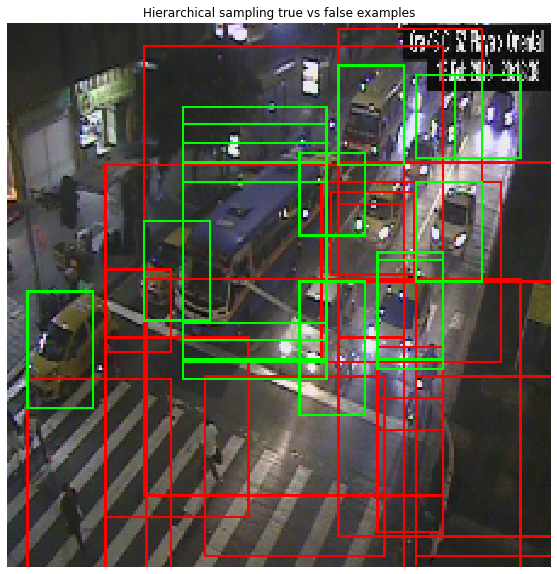

In [6]:
tensor = next(iter(ds))
anchors = tensor[1].numpy()
img = tensor[0].numpy()[:, :]

neg = anchors[anchors[:, 0] == -1]
pos = anchors[anchors[:, 0] != -1]

img = plot_bb(img, neg, (255, 0, 0), 1)
img = plot_bb(img, pos, (0, 255, 0), 1)

plt.figure(figsize = (10,10))
plt.imshow(img)
plt.axis('off')
plt.title('Hierarchical sampling true vs false examples');

In [7]:
tensor = next(iter(ds))

In [8]:
_, anchor_bbox, ground_truth = tensor

In [9]:
anchors = tf.cast(tf.constant(gen_anch()), tf.int32)

conv_move = tf.constant(compute_stride_from_receptive_field(),
                        dtype=tf.int32)
grid_size = len(conv_move)
k = len(anchors)

dx = conv_move
dy = conv_move

dy = tf.reshape(dy, (-1, 1, 1))
dx = tf.reshape(dx, (1, -1, 1))

dx = tf.concat([dx, tf.zeros((1, grid_size, 1), dtype=tf.int32)], axis=-1)
dy = tf.concat([tf.zeros((grid_size, 1, 1), dtype=tf.int32), dy], axis=-1)

reference = tf.reshape(dx + dy, (1, grid_size, grid_size, 1, 2))
reference = tf.concat([reference, reference], axis=-1)

anchors = reference + tf.reshape(anchors, (1, 1, 1, k, 4))
anchors = tf.transpose(anchors, [0, 2, 1, 3, 4])

In [10]:
print(anchors[0, 0, 0, 0])
print(anchors[0, 1, 0, 0])
print(anchors[0, 0, 1, 0])

tf.Tensor([ 5  5 39 39], shape=(4,), dtype=int32)
tf.Tensor([21  5 55 39], shape=(4,), dtype=int32)
tf.Tensor([ 5 21 39 55], shape=(4,), dtype=int32)


In [11]:
cond = tf.equal(tf.reshape(anchor_bbox[:, 1:], (-1, 1, 1, 1, 4)), anchors)
cond = tf.reduce_all(cond, axis=-1)
anchor_map = tf.cast(tf.where(cond), tf.int32)

#anchor_map # De aqui sacaré los k

In [12]:
anchor_map

<tf.Tensor: id=449, shape=(2, 4), dtype=int32, numpy=
array([[25,  1, 11,  1],
       [30,  9, 10,  0]], dtype=int32)>

In [13]:
anchor_bbox

<tf.Tensor: id=398, shape=(32, 5), dtype=int32, numpy=
array([[ -1,  56,  73, 179, 227],
       [  5,   8, 110,  35, 158],
       [ -1,  88, 145, 115, 186],
       [ -1, 136,  66, 195, 170],
       [ -1,  88,  94, 115, 142],
       [ -1,  56,  10, 179, 257],
       [ -1,  88,  73, 147, 162],
       [ -1,  72, 130, 131, 234],
       [  0,  72,  41, 131, 130],
       [ -1,  40,  34,  99, 138],
       [  8, 152,  37, 179,  71],
       [  9, 136,  17, 163,  58],
       [ -1,  24,   9, 147, 163],
       [  2, 168,  65, 195, 106],
       [  9, 136,  17, 163,  58],
       [  1, 120, 106, 147, 161],
       [  0,  72,  41, 131, 130],
       [  3, 152,  97, 179, 138],
       [ -1,  56, 146, 115, 250],
       [ -1,   8,  34,  67, 138],
       [  3, 152,  94, 179, 142],
       [  3, 152,  94, 179, 142],
       [ -1,  88, 181, 115, 215],
       [ -1,  40,  41, 163, 226],
       [  0,  72,  57, 131, 146],
       [ -1,   1, 161,  75, 235],
       [ -1, 184,  69, 211, 103],
       [  6,  56,  81,  83,

In [13]:
dx

<tf.Tensor: id=411, shape=(1, 12, 2), dtype=int32, numpy=
array([[[ 22,   0],
        [ 38,   0],
        [ 54,   0],
        [ 70,   0],
        [ 86,   0],
        [102,   0],
        [118,   0],
        [134,   0],
        [150,   0],
        [166,   0],
        [182,   0],
        [198,   0]]], dtype=int32)>

In [14]:
gt_pointer = anchor_bbox[:, :1]
p_raw = tf.cast(gt_pointer != -1, tf.int32)

In [15]:
p_loc_raw = tf.cast(anchor_map[:, -1:] * 2, tf.int32) + p_raw
p_loc = tf.concat([anchor_map[:, 1:-1], p_loc_raw], axis=-1)
p_loc

InvalidArgumentError: Incompatible shapes: [7,1] vs. [32,1] [Op:AddV2] name: add/

In [19]:
p_loc[10]

<tf.Tensor: id=481, shape=(3,), dtype=int32, numpy=array([12,  8,  0], dtype=int32)>

In [17]:
p_template = np.zeros((12, 12, 70))
p = tf.tensor_scatter_nd_update(p_template, p_loc, tf.ones(32)) ####### HERE

InvalidArgumentError: indices[10] = [12, 8, 0] does not index into shape [12,12,70] [Op:TensorScatterUpdate]

In [18]:
gt_mask = tf.cast(p_raw[:,0], tf.bool)#, gt_pointer)
pointers = tf.gather(gt_pointer, tf.where(gt_mask)[:, 0])[:, 0]
tf.gather(ground_truth, pointers)[:, 1:]

<tf.Tensor: id=499, shape=(14, 4), dtype=int32, numpy=
array([[ 53,  82,  78, 120],
       [150,  98, 176, 143],
       [161,  45, 177,  70],
       [ 72,  55, 131, 131],
       [123,  51, 138,  78],
       [ 72,  55, 131, 131],
       [107,  99, 145, 154],
       [177,  65, 193,  98],
       [139,  18, 168,  59],
       [196,  28, 211,  46],
       [ 72,  55, 131, 131],
       [174,  31, 189,  49],
       [  8, 111,  47, 156],
       [141,  64, 165,  94]], dtype=int32)>

In [19]:
ext_ground_truth = tf.concat([ground_truth, [[-1, 1, 2, 3, 4]]], axis=0)

In [20]:
_gt = tf.gather(ext_ground_truth,
                tf.where(tf.equal(-1, gt_pointer),
                         len(ground_truth) * tf.ones_like(gt_pointer),
                         gt_pointer ))[:, 0, 1:]

_gt = change_box_order(tf.cast(_gt, tf.float64))
_bb = change_box_order(tf.cast(anchor_bbox[:, 1:], tf.float64))

In [21]:
t_x = (_gt[:, 0] - _bb[:, 0]) / _bb[:, 2]
t_x = tf.reshape(t_x, (-1, 1))
t_y = (_gt[:, 1] - _bb[:, 1]) / _bb[:, 3]
t_y = tf.reshape(t_y, (-1, 1))
t_w = tf.math.log(_gt[:, 2] / _bb[:, 2])
t_w = tf.reshape(t_w, (-1, 1))
t_h = tf.math.log(_gt[:, 3] / _bb[:, 3])
t_h = tf.reshape(t_h, (-1, 1))
t_bbox = tf.concat([t_x, t_y, t_w, t_h], axis=-1)

In [22]:
t_loc_raw = tf.cast(anchor_map[:, -1:], tf.int32)
t_loc = tf.concat([anchor_map[:, 1:-1], t_loc_raw], axis=-1)

In [23]:
t_loc

<tf.Tensor: id=618, shape=(32, 3), dtype=int32, numpy=
array([[ 4,  2,  1],
       [ 6,  1, 12],
       [ 2,  3,  4],
       [ 4,  6,  6],
       [ 2,  6, 16],
       [ 5,  4, 14],
       [ 5,  4, 16],
       [ 5,  2, 16],
       [ 3,  3,  5],
       [ 4,  2, 17],
       [ 3,  6,  4],
       [ 6,  3, 16],
       [ 4,  2, 12],
       [ 3,  3,  1],
       [ 4,  4,  9],
       [ 6,  2,  9],
       [ 5,  1,  4],
       [ 6,  1,  8],
       [ 3,  3,  5],
       [ 3,  5,  6],
       [ 5,  2,  4],
       [ 3,  2, 10],
       [ 5,  3,  9],
       [ 2,  6,  2],
       [ 6,  4,  6],
       [ 5,  1,  0],
       [ 1,  4,  1],
       [ 4,  6, 17],
       [ 4,  4, 10],
       [ 5,  2,  4],
       [ 6,  6, 16],
       [ 5,  3, 14]], dtype=int32)>

In [24]:
t_template = np.zeros((12, 12, k, 4))
t = tf.tensor_scatter_nd_update(t_template, t_loc, t_bbox) ###### HERE

In [25]:
t.shape

TensorShape([12, 12, 20, 4])